<h1 style="text-align:center">Advanced Statistical Inference</h1>
<h1 style="text-align:center">Bayesian Logistic Regression - Metropolis-Hastings</h1>



## 1. Aims
<div class="alert alert-info">
<ul> 
<li> To implement the MH algorithm.
<li> To use it to compute classification probabilities.
</ul>
</div>

## 2. Metropolis-Hastings
<div class="alert alert-info">
In this lab, you’re going to implement the Metropolis-Hasting algorithm described in the lecture.
Use the binary classification data `binaryclass2.mat` and the function `laplacecomp()`. If you
pass this function a 2-dimensional $w$ vector, it will return $g(w; X, t, \sigma^2)$ and $log(g(w; X, t, \sigma^2))$.
(Remember that $g(w; X, t, \sigma^2) \propto p(w|X, t, \sigma^2)$, the posterior density of interest.)
</div>

In [9]:
import scipy.io
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
mat = scipy.io.loadmat('binaryclass2.mat')

In [10]:
X = mat['X']
t = mat['t']

<div class="alert alert-info">
Visualise the data using a scatter plot.
</div>

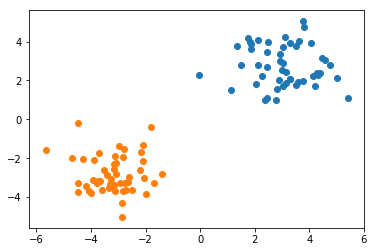

In [22]:
pos = np.array([x for (i, x) in enumerate(X) if t[i] == 1])
neg = np.array([x for (i, x) in enumerate(X) if t[i] == 0])
plt.scatter(pos[:,0], pos[:,1])
plt.scatter(neg[:,0], neg[:,1])

<div class="alert alert-info">
Make sure `laplacecomp()` works by passing it some different $w$ vectors ($w$ needs to have
dimension 2×1).</div>

In [4]:
def laplacecomp(w,X,t):
    """This function computes g and log(g) for the laplace model introduced in the lecture."""
    w = np.array(w)
    X = np.array(X)
    t = np.array(t)
    ss = 10 # Prior variance (sigma squared)
    # Evaluate log prior
    log_g = -(1/(2*ss))*w.T.dot(w)
    # Compute P
    P = 1/(1+np.exp(-X.dot(w)))
    log_l = np.sum(t*np.log(P) + (1-t)*(np.log(1-P)))
    log_g = log_g + log_l
    g = np.exp(log_g)
    return g[0][0], log_g[0][0]

In [26]:
w1 = np.array([1, 2]).reshape(-1 ,1)
laplacecomp(w1, X, t)

(0.6482181560305046, -0.43352797874640425)

<div class="alert alert-info">

Implement the MH algorithm (see the flowchart in the slides). 
<br>
You might find it safest to work with $log(g)$ – the ratio then becomes a subtraction that must then be exponentiated. This has more numerical stability, especially when $w$ isn’t very good. You can start with any value of $w$. E.g., $w = randn(2,1)$. Also, use a Gaussian proposal: For example: $wp = randn(2,1)*0.5+w$ where $w$ is the current sample and $wp$ is the proposal and the Gaussian has standard deviation $0.5$ (set this as you please).
</div>

In [31]:
def MH(X, t, numSamples):
    STD = 0.5 # Gaussian's starndard deviation
    
    # Initialize
    s = 0
    w = np.random.randn(2, 1)
    
    accepted_values = list()
    
    while s < numSamples:
        # Generate proposal
        wp = np.random.randn(2, 1) * 0.5 + w

        # Compute acceptance ratio
        gp, loggp = laplacecomp(wp, X, t)
        gs, loggs = laplacecomp(w, X, t)
        
        r = loggp - loggs
        r = np.exp(r)

        if r >= 1:
            # Accept proposal
            w = wp
        else:
            # Accept the proposal with probability r
            u = np.random.uniform(0, 1)
            if u <= r:
                w = wp
        accepted_values.append(w)
        s += 1
    return np.array(accepted_values)

<div class="alert alert-info">
Draw samples from your MH algorithm and plot the distribution of values obtained.
</div>

In [42]:
numSamples = 10000
w_samples = MH(X,t, numSamples)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()


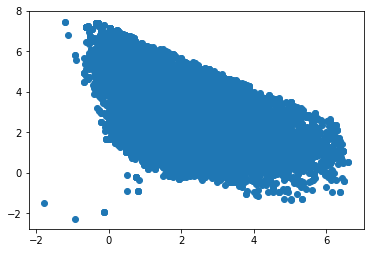

In [43]:
plt.scatter(w_samples[:,0,:], w_samples[:,1,:])

<div class="alert alert-info">
Compute the probability $P (t_{new} = 1 | x_{new} , X, t)$ when $x_{new} = [2,-4]^T$ . 
<br>
Hint – compute the probability for each value of $w$ using:
$$ \dfrac{1}{1+\exp(-w^T x_{new})} $$
</div>

In [59]:
def predict(samples, x_new):
    p = 0
    
    for ws in samples:
        den = np.dot(x_new, -ws)
        p += 1 / (1 + np.exp(den))
    
    return float(p/len(samples))

In [60]:
x_new = np.array([2,-4])
predict(w_samples, x_new)

0.24975275580284356

<div class="alert alert-success">
Create a contour plot over the given range of values, while also showing the prediction for ${x_{new}}$.
</div>

In [61]:
x1min, x1max, x1step = (-6, 6.5, 0.5)
x2min, x2max, x2step = (-6, 6.5, 0.5)
x1_range = np.arange(x1min, x1max, x1step)
x2_range = np.arange(x2min, x2max, x2step)

# Compute probabilities
p = list()
for x1 in x1_range:
    p_new = list()
    for x2 in x2_range:
        x_new = np.array([x1,x2])
        p_new.append(predict(w_samples, x_new))
    p.append(p_new)

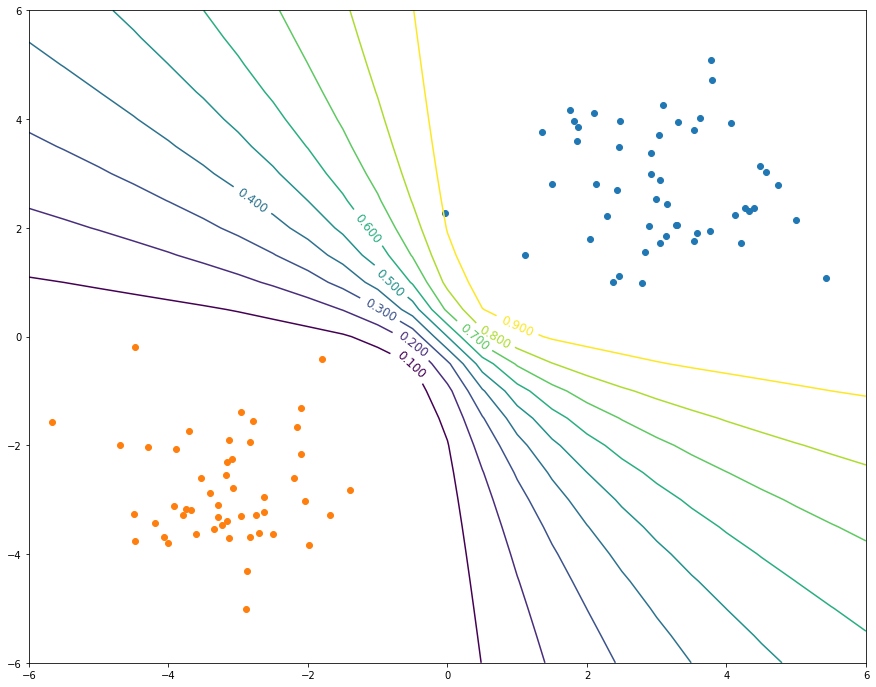

In [68]:
plt.figure(figsize=(15,12))
g = plt.contour(x1_range, x2_range, p, 10)
plt.clabel(g, inline=1, fontsize=12)
pos = np.array([x for (i, x) in enumerate(X) if t[i] == 1])
neg = np.array([x for (i, x) in enumerate(X) if t[i] == 0])
plt.scatter(pos[:,0], pos[:,1])
plt.scatter(neg[:,0], neg[:,1])
plt.show()